In [1]:
# Implementing the paper https://arxiv.org/abs/1704.02019
# Associative Content Addressable Memory with Exponentially Many Robust Stable States

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
'''See: https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners'''

import matplotlib.cm as cm # color maps

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Bottom layer has N neurons, called input neurons
# Second layer is constraint layer, has N_c ~ N small sub-networks
# The small sub-networks are called constraint nodes
# ith input neuron connects to z_i constraint nodes
# jth constraint node connects to z_j_c input neurons

# Each neuron in a given constraint node is connected to the same set of input neurons

# M is the number of neurons in each constraint node


input to constraint node connectivity
[[0, 1, 3, 4, 5], [0, 1, 4, 5, 3], [0, 1, 4, 3, 2], [5, 2, 3, 4, 0], [0, 3, 5, 2, 4], [0, 3, 5, 4, 1], [0, 2, 5, 1, 3], [4, 2, 1, 3, 0], [4, 5, 1, 2, 3], [3, 5, 0, 1, 4], [4, 2, 0, 5, 1], [0, 5, 4, 3, 2], [4, 0, 1, 2, 3], [0, 2, 4, 1, 5], [2, 0, 1, 3, 5]]


<IPython.core.display.Javascript object>


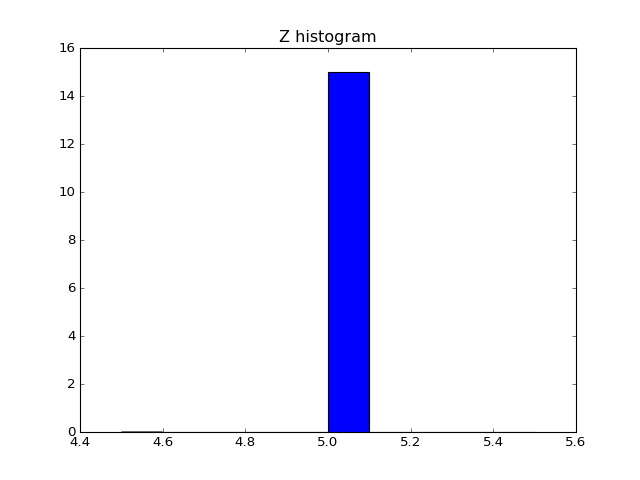


total outgoing edges
75

constraint node to input connectivity
[[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14], [0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 14], [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14], [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13], [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14]]


<IPython.core.display.Javascript object>


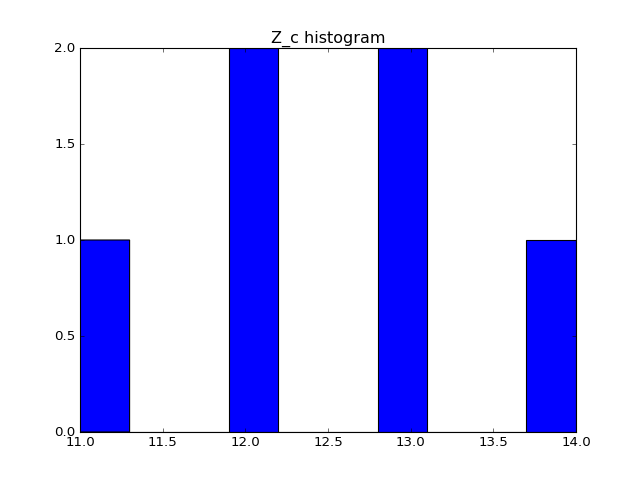


total incoming edges
75


In [4]:
# First define the connectivity

N = 15

N_c = int(5*N/12)

M = 2

z = 5

input_to_constraint_node_connectivity = []
for i in range(N):
    input_to_constraint_node_connectivity.append(np.ndarray.tolist(np.random.choice(range(N_c), size = z, replace = False)))

print "\ninput to constraint node connectivity"
print input_to_constraint_node_connectivity
    
constraint_node_to_input_connectivity = []
for i in range(N_c):
    temp = []
    for j in range(N):
        if i in input_to_constraint_node_connectivity[j]:
            temp.append(j)
    constraint_node_to_input_connectivity.append(temp)
    
plt.figure()
plt.title("Z histogram")
plt.hist([len(q) for q in input_to_constraint_node_connectivity])
plt.show()

print "\ntotal outgoing edges"
print np.sum([len(q) for q in input_to_constraint_node_connectivity])

print "\nconstraint node to input connectivity"
print constraint_node_to_input_connectivity

plt.figure()
plt.title("Z_c histogram")
plt.hist([len(q) for q in constraint_node_to_input_connectivity])
plt.show()

print "\ntotal incoming edges"
print np.sum([len(q) for q in constraint_node_to_input_connectivity])

In [5]:
def generate_random_parity_states(input_size, num_parity_states_to_generate):
    parity_states = []
    for i in range(num_parity_states_to_generate):
        parity = 1
        state = []
        while parity == 1:
            state = np.random.randint(0,2,size = input_size)
            parity = sum(state) % 2
            if parity == 0:
                parity_states.append(state)

    return parity_states

print generate_random_parity_states(5, 10)

[array([1, 0, 0, 1, 0]), array([0, 1, 0, 1, 0]), array([1, 1, 0, 0, 0]), array([0, 1, 1, 1, 1]), array([1, 1, 0, 0, 0]), array([1, 0, 1, 1, 1]), array([1, 0, 1, 1, 1]), array([0, 1, 0, 0, 1]), array([0, 1, 1, 1, 1]), array([1, 1, 1, 1, 0])]


In [6]:
def generate_constraint_node_neurons(constraint_node_index):
    neurons = []
    for i in range(M):
        neuron = {}
        neuron["inputs"] = constraint_node_to_input_connectivity[constraint_node_index]
        neuron["num_inputs"] = len(neuron["inputs"])
        neuron["preferred_parity_config"] = generate_random_parity_states(neuron["num_inputs"], 1)[0]
        neuron["ones"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 1] 
        neuron["minus_ones"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 0]
        neuron["bias_term"] = neuron["num_inputs"] - np.sum(neuron["preferred_parity_config"])
        neurons.append(neuron)
    return neurons
    
constraint_node_example = generate_constraint_node_neurons(2)
for m in constraint_node_example:
    print m

{'inputs': [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14], 'minus_ones': [2, 7, 12], 'num_inputs': 11, 'preferred_parity_config': array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]), 'ones': [3, 4, 6, 8, 10, 11, 13, 14], 'bias_term': 3}
{'inputs': [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14], 'minus_ones': [2, 4, 6, 8, 10, 11, 13], 'num_inputs': 11, 'preferred_parity_config': array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]), 'ones': [3, 7, 12, 14], 'bias_term': 7}


In [7]:
# Generating the full weight matrix and biases

total_number_neurons = N + N_c*M

full_weight_matrix = [[0 for j in range(total_number_neurons)] for i in range(total_number_neurons)]
biases = [0 for j in range(total_number_neurons)]

for node in range(N_c): # Index over constraint nodes
    neurons_in_node = generate_constraint_node_neurons(node) # Generate neurons in that constraint node
    for m in range(M):
        neuron_full_index = N + node*M + m
        neuron = neurons_in_node[m]
        for g in neuron["ones"]: # constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = 1
            full_weight_matrix[g][neuron_full_index] = 1
        for g in neuron["minus_ones"]: # constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = -1
            full_weight_matrix[g][neuron_full_index] = -1
        for p in range(M): # inhibitory internal connectivity within the same node
            p_full_index = N + node*M + p
            if p != m:
                full_weight_matrix[neuron_full_index][p_full_index] = -1*(neuron["num_inputs"] - 1)
                full_weight_matrix[p_full_index][neuron_full_index] =  -1*(neuron["num_inputs"] - 1)
        biases[neuron_full_index] = neuron["bias_term"]


<IPython.core.display.Javascript object>


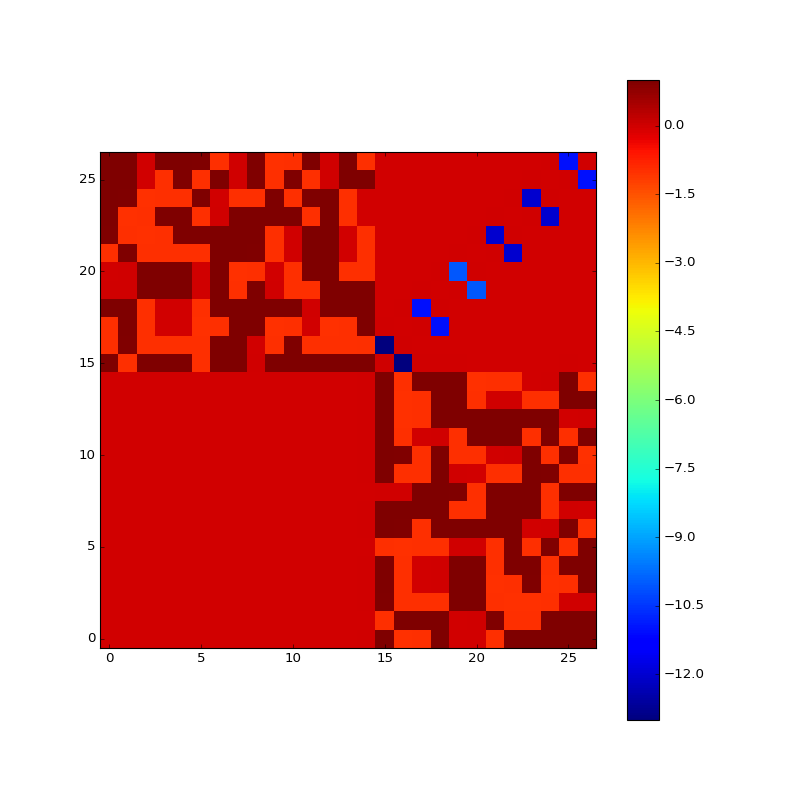

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.figure()
plt.imshow(full_weight_matrix, interpolation='none')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()